In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

import model, inference

from importlib import reload
reload(model)
reload(inference)

<module 'inference' from '/storage/coda1/p-awu36/0/cli726/vis/mixture/inference.py'>

In [58]:
method_list = [ 'VI', 'CHIVI', 'VBIS', 'VIS']
seed_list = np.arange(10)
df_list = []

for method in method_list:
    for seed in seed_list:
        try:
            df_temp = pd.read_csv(f'csv/{method}_{seed}.csv')
            df_temp['method'] = method
            df_temp['seed'] = seed
            df_list.append(df_temp)
        except:
            print(method)

df = pd.concat(df_list, ignore_index=True)

In [3]:
def my_barplot(x, y, data, **args):
    ax = sns.barplot(x=x, y=y, data=data, **args)
    ax.set(xlabel=None)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_visible(False)
    # ax.get_legend().remove()
    return ax


def plot_posterior(gen_model, inf_model, vari_model, ax):
    z0 = torch.linspace(-15, 5, 100)
    x0 = torch.zeros_like(z0)
    y = gen_model.complete_log_likelihood(z0, x0).exp()
    y = y / y.sum() / (z0[1] - z0[0])
    ax.plot(z0, y, c='C4', linestyle='--', label=r'$p(z|x=0;\theta^{\mathrm{true}})$')
    ax.plot(z0, vari_model.hid_log_likelihood(z0, 0).exp(), c='C4', linestyle='dotted', label=r'$q(z|x=0;\phi)$')
    y = inf_model.complete_log_likelihood(z0, x0).exp()
    y = y / y.sum() / (z0[1] - z0[0])
    ax.plot(z0, y, c='C4', label=r'$p(z|x=0;\theta)$')
    z1 = torch.linspace(-5, 15, 100)
    x1 = torch.ones_like(z1)
    y = gen_model.complete_log_likelihood(z1, x1).exp()
    y = y / y.sum() / (z1[1] - z1[0])
    ax.plot(z1, y, c='C5', linestyle='--', label=r'$p(z|x=1;\theta^{\mathrm{true}})$')
    ax.plot(z1, vari_model.hid_log_likelihood(z1, 1).exp(), c='C5', linestyle='dotted', label=r'$q(z|x=1;\phi)$')
    y = inf_model.complete_log_likelihood(z1, x1).exp()
    y = y / y.sum() / (z1[1] - z1[0])
    ax.plot(z1, y, c='C5', label=r'$p(z|x=1;\theta)$')
    return ax

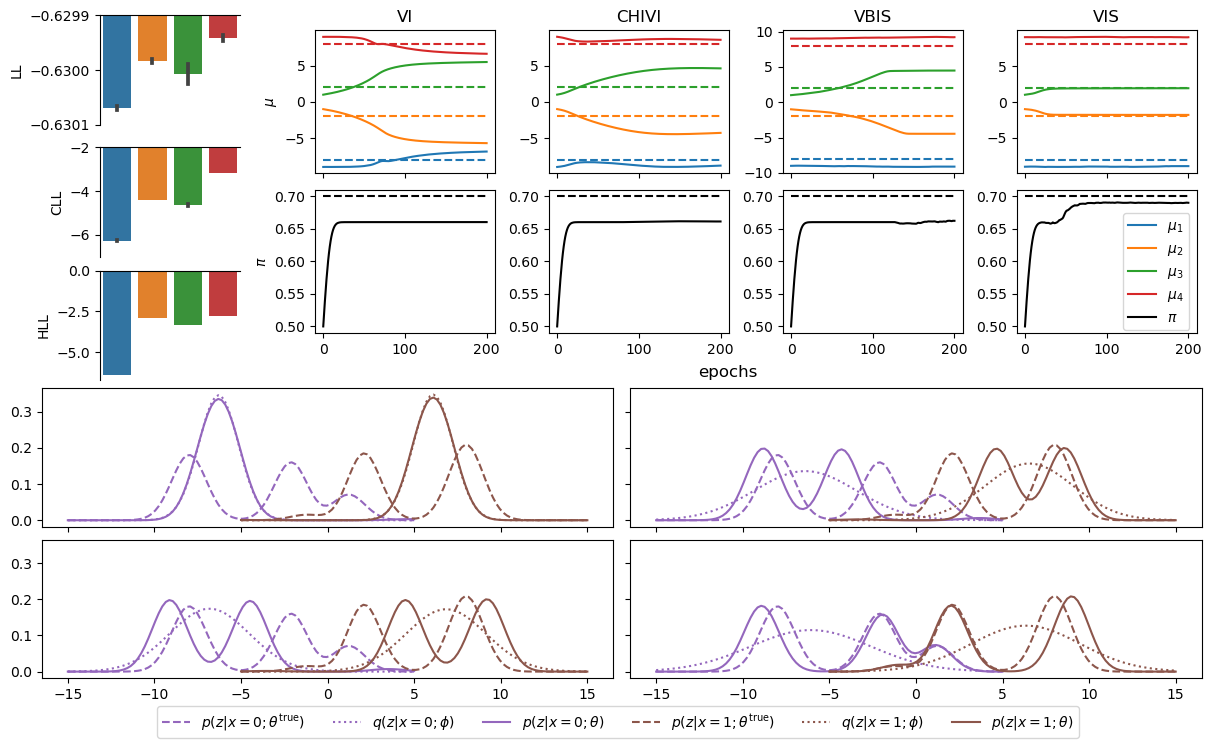

In [56]:
plt.rc('font', **{'size': 10})
seed = 5
n_epochs = 200

mu_list = torch.tensor([-8, -2, 2, 8.])

fig = plt.figure(layout='constrained', figsize=(12, 7))
subfigs = fig.subfigures(2, 1, hspace=0, height_ratios=[1, 0.85])

subsubfigs = subfigs[0].subfigures(1, 2, wspace=0.01, width_ratios=[1, 4])

axs = subsubfigs[0].subplots(3, 1)
ax = my_barplot(x='method', y='marginal log-likelihood uniform', data=df, ax=axs[0], order=method_list)
ax.set_ylim(-0.6301, -0.6299)
ax.set_ylabel('LL')

ax = my_barplot(x='method', y='pred complete log-likelihood', data=df, ax=axs[1], order=method_list)
ax.set_ylim(-7, -2)
ax.set_ylabel('CLL')

ax = my_barplot(x='method', y='hidden log-likelihood', data=df, ax=axs[2], order=method_list)
ax.set_ylabel('HLL')

axs = subsubfigs[1].subplots(2, 4, sharex=True)
for i, method in enumerate(method_list):
    record_mu = np.load(f'np/{method}_{seed}_mu.npy')[:, :n_epochs+1]
    record_pi = np.load(f'np/{method}_{seed}_pi.npy')[:n_epochs+1]
    for j in range(4):
        axs[0, i].plot(range(n_epochs + 1), record_mu[j], c=f'C{j}', label=f'$\\mu_{j+1}$')
        axs[0, i].plot([0, n_epochs], [mu_list[j], mu_list[j]], c=f'C{j}', linestyle='--')
        axs[0, i].set_title(f'{method_list[i]}')
    axs[0, 0].set_ylabel('$\mu$')
    axs[1, i].plot(range(n_epochs + 1), record_pi, 'k', label="$\\pi$")
    axs[1, i].plot([0, n_epochs], [0.7, 0.7], 'k--')
    axs[1, 0].set_ylabel('$\pi$')
subsubfigs[1].supxlabel('epochs')

handles_mu, labels_mu = axs[0, 0].get_legend_handles_labels()
handles_pi, labels_pi = axs[1, 0].get_legend_handles_labels()
subsubfigs[1].legend(handles=handles_mu + handles_pi, labels=labels_mu + labels_pi, bbox_to_anchor=(0.99, 0.47))

gen_model = model.GMM4Bernoulli(torch.tensor(0.7), mu_list)

gen_model = model.GMM4Bernoulli(torch.tensor(0.7), mu_list)
with torch.no_grad():
    axs = subfigs[1].subplots(2, 2, sharex=True, sharey=True)
    
    vari_model = model.Post2Gaussian(torch.zeros(2), torch.ones(2))
    vari_model.load_state_dict(torch.load(f'model/VI_{seed}_vari.pt'))
    inf_model = model.GMM4Bernoulli(torch.tensor(0.7), mu_list)
    inf_model.load_state_dict(torch.load(f'model/VI_{seed}_inf.pt'))
    plot_posterior(gen_model, inf_model, vari_model, axs[0, 0])
    
    ari_model = model.Post2Gaussian(torch.zeros(2), torch.ones(2))
    vari_model.load_state_dict(torch.load(f'model/CHIVI_{seed}_vari.pt'))
    inf_model = model.GMM4Bernoulli(torch.tensor(0.7), mu_list)
    inf_model.load_state_dict(torch.load(f'model/CHIVI_{seed}_inf.pt'))
    plot_posterior(gen_model, inf_model, vari_model, axs[0, 1])
    
    ari_model = model.Post2Gaussian(torch.zeros(2), torch.ones(2))
    vari_model.load_state_dict(torch.load(f'model/VBIS_{seed}_vari.pt'))
    inf_model = model.GMM4Bernoulli(torch.tensor(0.7), mu_list)
    inf_model.load_state_dict(torch.load(f'model/VBIS_{seed}_inf.pt'))
    plot_posterior(gen_model, inf_model, vari_model, axs[1, 0])
    
    ari_model = model.Post2Gaussian(torch.zeros(2), torch.ones(2))
    vari_model.load_state_dict(torch.load(f'model/VIS_{seed}_vari.pt'))
    inf_model = model.GMM4Bernoulli(torch.tensor(0.7), mu_list)
    inf_model.load_state_dict(torch.load(f'model/VIS_{seed}_inf.pt'))
    plot_posterior(gen_model, inf_model, vari_model, axs[1, 1])

handles, labels = axs[1, 1].get_legend_handles_labels()
subfigs[1].legend(handles, labels, bbox_to_anchor=(0.9, 0.02), ncol=6)

fig.savefig('mixture.pdf', bbox_inches='tight', transparent=True)